In [1]:
import os, utils
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from model.modelmlp import ModelMLP
from tqdm import tqdm
from losses.losses import ssm_loss
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

sns.set(style="darkgrid")
mpl.rcParams['figure.dpi'] = 100
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

seed=42
tf.random.set_seed(seed)
np.random.seed(seed)

tf.__version__

'2.3.1'

In [2]:
a = 1
s1 = 2
s2 = 3

num_samples = 1000000

x1 = np.random.normal(a, s1, size=num_samples)
x2 = np.random.normal(0, s2, size=num_samples)

x_sigma_add = np.random.normal(a, s2, size=num_samples)
x_gauss_add = np.random.normal(a, np.sqrt(s1**2+s2**2), size=num_samples)
x_sum = x1 + x2

In [3]:
print("x_sum:", np.mean(x_sum), np.std(x_sum))
print("x_sigma_add:", np.mean(x_sigma_add), np.std(x_sigma_add))
print("x_gauss_add:", np.mean(x_gauss_add), np.std(x_gauss_add))

x_sum: 0.9960707275973596 3.6105081558203564
x_sigma_add: 1.000563946013736 2.999309715907416
x_gauss_add: 1.0022001141788606 3.602631312084817


In [4]:
a, np.sqrt(s1**2 + s2**2)

(1, 3.605551275463989)

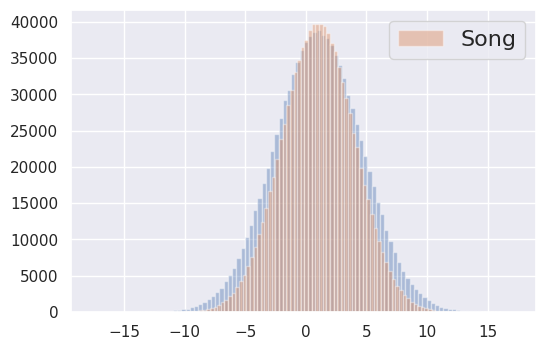

In [5]:
sns.distplot(x_sum, kde=False, bins=100)
sns.distplot(x_sigma_add, label="Song", kde=False, bins=100)
plt.legend()

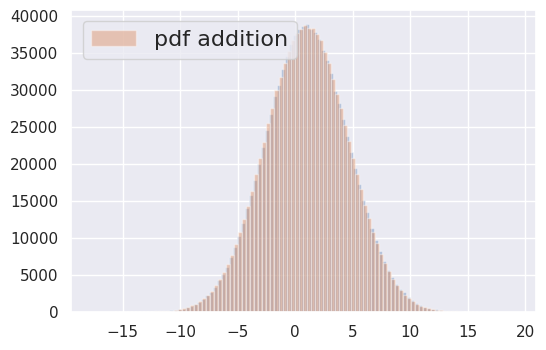

In [6]:
sns.distplot(x_sum, kde=False, bins=100)
sns.distplot(x_gauss_add, label="pdf addition", kde=False, bins=100)
plt.legend()

In [7]:

tfd = tfp.distributions

def GMM(probs, loc, scale):
    gmm = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=probs),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=loc,
            scale_identity_multiplier=scale))
    return gmm


def meshgrid(x):
    y = x
    [gx, gy] = np.meshgrid(x, y, indexing='ij')
    gx, gy = np.float32(gx), np.float32(gy)
    grid = np.concatenate([gx.ravel()[None, :], gy.ravel()[None, :]], axis=0)
    return grid.T.reshape(x.size, y.size, 2)


def visualize_density(gmm, x):
    grid = meshgrid(x)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(gmm.prob(grid), cmap='inferno', extent=[-12, 12, -12, 12], origin='lower')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
#     plt.savefig("density.pdf", bbox_inches="tight")
    plt.show()
    return


def sample(gmm, nr_samples):
    s = tfd.Sample(gmm, sample_shape=nr_samples)
    return s.sample()


def visualize_samples(samples, filename="samples"):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.scatter(samples.numpy()[:, 0], samples.numpy()[:, 1], marker='.', color="black")
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
#     ax.set_xlim(-10, 10)
#     ax.set_ylim(-10, 10)
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")
    plt.show()
    return

def visualize_gradients(x, grads, filename="gradients"):
    U, V = grads[:, :, 1], grads[:, :, 0]
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.quiver(x, x, U, V)
    plt.gca().set_aspect('equal', adjustable='box')     
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$y$')
    plt.savefig(f"{filename}.pdf", bbox_inches="tight")

    

@tf.function
def langevin_dynamics(grad_function, gmm, x, sigma_i=None, alpha=0.1, T=1000):
    for t in range(T):
        score = grad_function(gmm, x, sigma_i)
        noise = tf.sqrt(alpha) * tf.random.normal(shape=x.get_shape(), mean=0, stddev=1.0)
        x = x + (alpha / 2) * score + noise
    return x


def annealed_langevin_dynamics(grad_function, gmm, x, sigmas, eps=0.1, T=100):
    for i, sigma_i in enumerate(sigmas):
        alpha_i = eps * (sigma_i ** 2) / (sigmas[-1] ** 2)
        x = langevin_dynamics(grad_function, gmm, x, sigma_i=sigma_i, alpha=alpha_i, T=T)
    return x

In [8]:
# @tf.function
def analytic_log_prob_grad_1d(gmm, x, sigma_i=None):
    x_tensor = tf.convert_to_tensor(x)
    with tf.GradientTape() as t:
        t.watch(x_tensor)
        if sigma_i is None:
            log_prob = gmm.log_prob(x_tensor)
        else:
#             sigma_i = tf.math.sqrt(sigma_i**2 + 1)
            mus = tf.convert_to_tensor(gmm.components_distribution.parameters["loc"], dtype=tf.float32)
            scales = tf.convert_to_tensor(gmm.components_distribution.parameters["scale"], dtype=tf.float32)
            mix_probs = gmm.mixture_distribution.probs
            scales = tf.math.sqrt(sigma_i**2 + scales**2)

            sigma_gmm = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=mix_probs),
                components_distribution=tfd.Normal(
                        loc=mus, scale=scales
                )
            )
            
            log_prob = sigma_gmm.log_prob(x_tensor)
    anal_gradients = t.gradient(log_prob, x_tensor)
    return anal_gradients

In [9]:
# mix_probs = [0.25]*4
# mus = [-15, 2.75,3,3.25]
# scales = [1, 3,4,3]

mix_probs = [0.95, 0.05]
mus = np.array([10, 50], dtype=np.float32)
scales = np.array([2, 2], dtype=np.float32)


xs = np.linspace(-10,75,1000, dtype=np.float32)
x_tensor = xs.reshape(-1, 1)

normals = tfd.Normal(
    loc=mus,
    scale=scales
)

gmm_1D = tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=mix_probs),
                components_distribution=normals
)

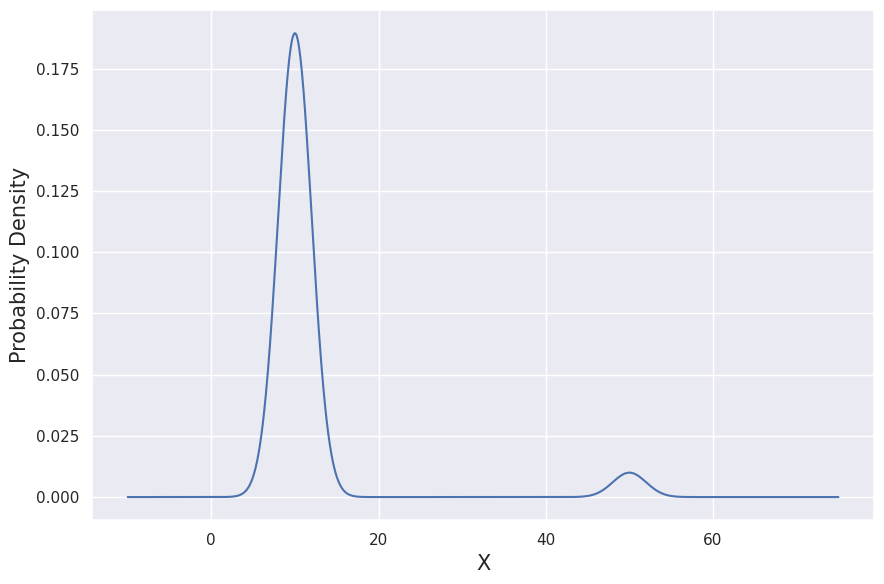

In [67]:
fig, ax = plt.subplots(1,1, figsize=(9,6))
ax.plot(xs, gmm_1D.prob(xs))
ax.set(ylabel="Probability Density", xlabel="X")

plt.tight_layout()
plt.savefig("gmm1d_nopts.png", dpi=200)

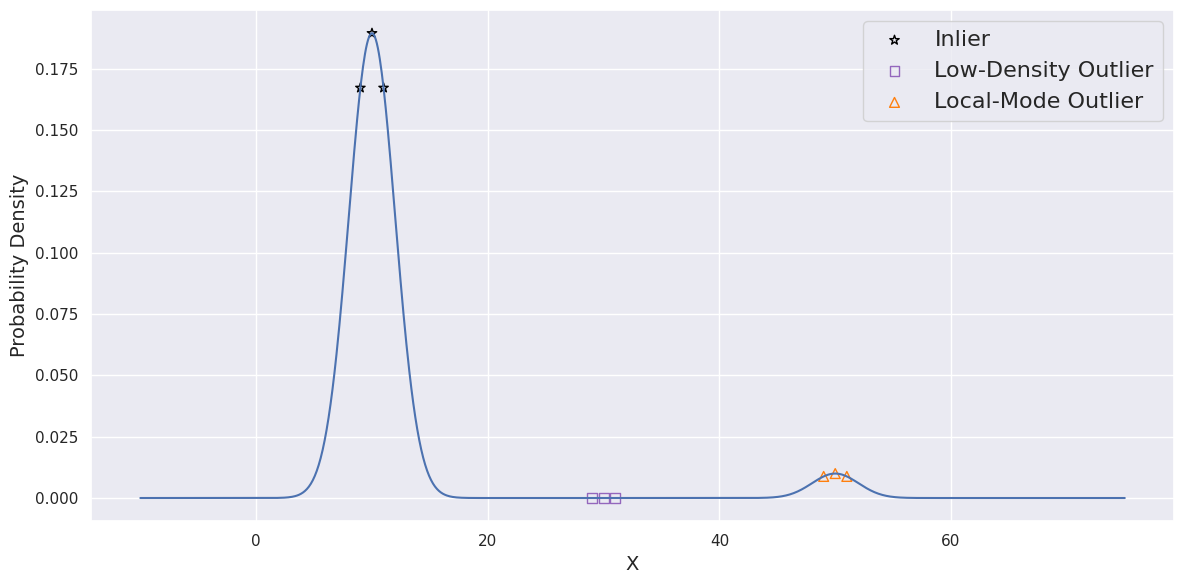

In [14]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.plot(xs, gmm_1D.prob(xs))

keypoints = np.array([9,10,11, 29,30,31, 49,50,51], dtype=np.float32)
regions = ["Inlier"]*3 + ["Low-Density Outlier"]*3 + ["Local-Mode Outlier"]*3
colors = ["black"]*3 + ["tab:purple"]*3 + ["tab:orange"]*3
markers = ["*"]*3 + ["s"]*3 + ["^"]*3


for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
    if i%3 != 0:
        l=""
    ax.scatter(kp, gmm_1D.prob(kp), marker=m, facecolors='none', edgecolors=c, label=l, s=50)
    
ax.set(ylabel="Probability Density", xlabel="X")
ax.legend()
plt.tight_layout()
plt.savefig("gmm1d.png", dpi=200)

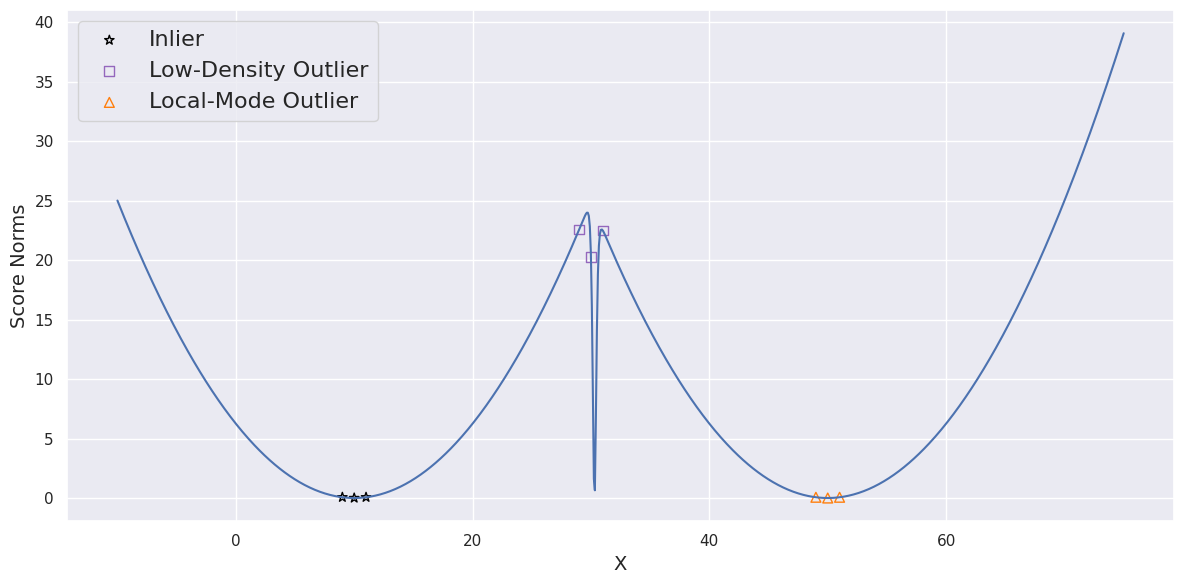

In [25]:
fig, ax = plt.subplots(1,1, figsize=(12,6))

_grad_norms = analytic_log_prob_grad_1d(gmm_1D, xs) ** 2
_kp_norms = analytic_log_prob_grad_1d(gmm_1D, keypoints) ** 2

ax.plot(xs, _grad_norms)

for i, (kp, kpn, c, m, l) in enumerate(zip(keypoints, _kp_norms, colors, markers, regions)):
    if i%3 != 0: l=""
    ax.scatter(kp, kpn, marker=m, edgecolors=c, s=50, facecolors='none', label=l)

ax.set(ylabel="Score Norms", xlabel="X")
ax.legend()
plt.tight_layout()
plt.savefig("score1d.png", dpi=200)

In [381]:
scales

array([2., 2.], dtype=float32)

In [29]:
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['legend.fontsize'] = 16

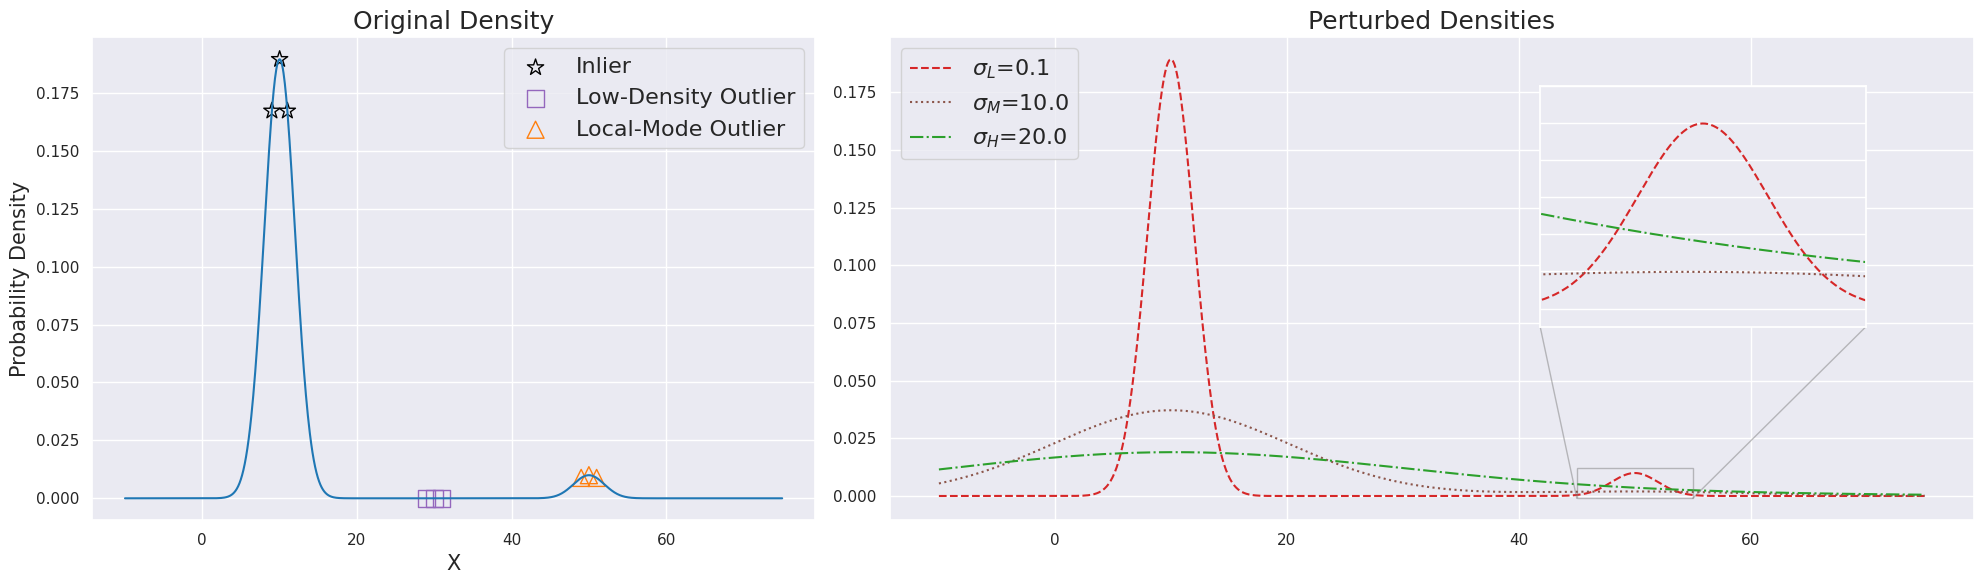

In [64]:
sigmas = [0.1,10,20]
pert_dists = []
fig, axs = plt.subplots(1,2, figsize=(20,6), gridspec_kw={'width_ratios': [2, 3]})

plot_colors = ["tab:red", "tab:brown", "tab:green"]
linestyles = ["dashed", "dotted", "dashdot"]
sigma_label = ["L", "M", "H"]

axs[0].plot(xs, gmm_1D.prob(xs), c="tab:blue")
for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
    if i%3 != 0:
        l=""
    axs[0].scatter(kp, gmm_1D.prob(kp), marker=m, facecolors='none', edgecolors=c, label=l, s=150)
    
axs[0].set(ylabel="Probability Density", xlabel="X")
axs[0].legend()


# inset axes....
# fig, ax = plt.subplots(1,1, figsize=(12,6))
axins = axs[1].inset_axes([0.6, 0.4, 0.3, 0.5])

for i, sigma_i in enumerate(sigmas):

    normals = tfd.Normal(
        loc=mus,
        scale = tf.math.sqrt(sigma_i**2 + scales**2)
    )

    gmm_1D_perturbed = tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(probs=mix_probs),
                    components_distribution=normals
    )

    pert_dists.append(gmm_1D_perturbed)
    
    axs[1].plot(xs, gmm_1D_perturbed.prob(xs),
                label="$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])
    
    
    
    axins.plot(xs, gmm_1D_perturbed.prob(xs),
                label=r"$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])

#     for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
# #         if i%3 != 0:
#         l=""
#         axs[0].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
#         axs[1].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
    
ax.set(xlabel="X")
ax.legend()

axs[0].set_title("Original Density")
axs[1].set_title("Perturbed Densities")
axs[1].legend()
# axs[1].set_title("Zoomed")
axins.set(yscale="linear",
           ylim=(-0.001, 0.012), xlim=(45,55),
           xticks=[])
axins.yaxis.set_ticklabels([])
axs[1].indicate_inset_zoom(axins)
# axins.tick_params(
#     axis='y',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off



plt.tight_layout()
plt.savefig("combined.png", dpi=200)

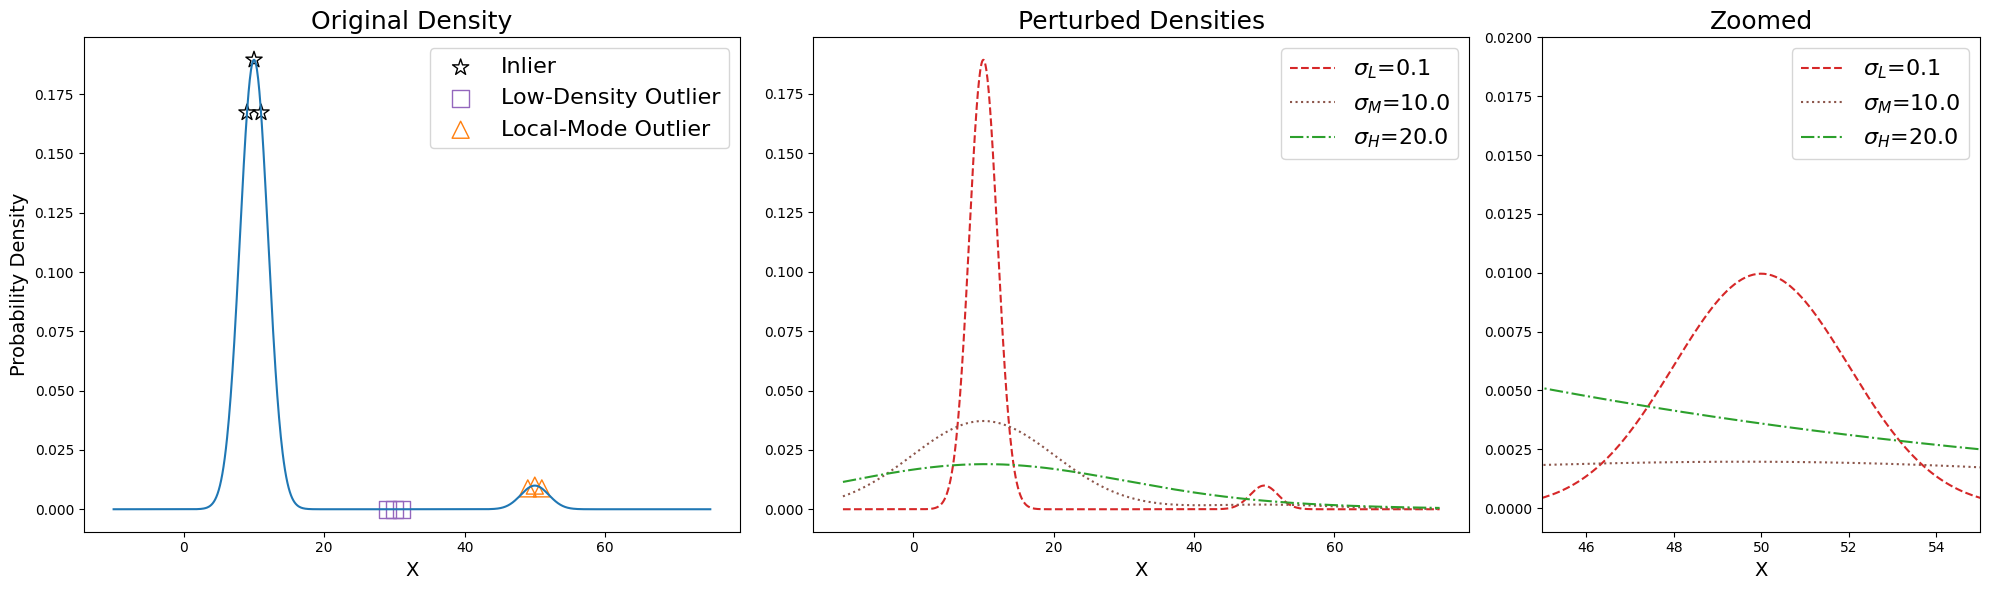

In [12]:
sigmas = [0.1,10,20]
pert_dists = []
fig, axs = plt.subplots(1,3, figsize=(20,6), gridspec_kw={'width_ratios': [3, 3, 2]})

plot_colors = ["tab:red", "tab:brown", "tab:green"]
linestyles = ["dashed", "dotted", "dashdot"]
sigma_label = ["L", "M", "H"]

axs[0].plot(xs, gmm_1D.prob(xs), c="tab:blue")
for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
    if i%3 != 0:
        l=""
    axs[0].scatter(kp, gmm_1D.prob(kp), marker=m, facecolors='none', edgecolors=c, label=l, s=150)
    
axs[0].set(ylabel="Probability Density", xlabel="X")
axs[0].legend()


for i, sigma_i in enumerate(sigmas):

    normals = tfd.Normal(
        loc=mus,
        scale = tf.math.sqrt(sigma_i**2 + scales**2)
    )

    gmm_1D_perturbed = tfd.MixtureSameFamily(
                    mixture_distribution=tfd.Categorical(probs=mix_probs),
                    components_distribution=normals
    )

    pert_dists.append(gmm_1D_perturbed)
    
    axs[1].plot(xs, gmm_1D_perturbed.prob(xs),
                label="$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])
    
    axs[2].plot(xs, gmm_1D_perturbed.prob(xs),
                label=r"$\sigma_{}$={:.1f}".format(sigma_label[i], sigma_i),
                c=plot_colors[i], linestyle=linestyles[i])

#     for i, (kp, c, m, l) in enumerate(zip(keypoints, colors, markers, regions)):
# #         if i%3 != 0:
#         l=""
#         axs[0].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
#         axs[1].scatter(kp, gmm_1D_perturbed.prob(kp), marker=m, c=c, label=l, s=50)
    
for ax in axs:
    ax.set(xlabel="X")
    ax.legend()

axs[0].set_title("Original Density")
axs[1].set_title("Perturbed Densities")
axs[2].set_title("Zoomed")
axs[2].set(yscale="linear",
           ylim=(-0.001, 0.02), xlim=(45,55))

# axs[2].set(ylim=(-10, -4), xlim=(45,55))

plt.tight_layout()
# plt.savefig("Figures/gmm_plot.png", dpi=200)

In [162]:
# fig, axs = plt.subplots(1,1, figsize=(10,6))
# axs.plot(xs, anal_grads, label="Original")
# axs.plot(xs, est_grads, label="Estimate")
# axs.plot(xs,anal_grads_perturbed, label="Noise Perturbed")
# axs.set(title="Gradients")
# plt.legend()

Text(0.5, 0.98, 'Scores')

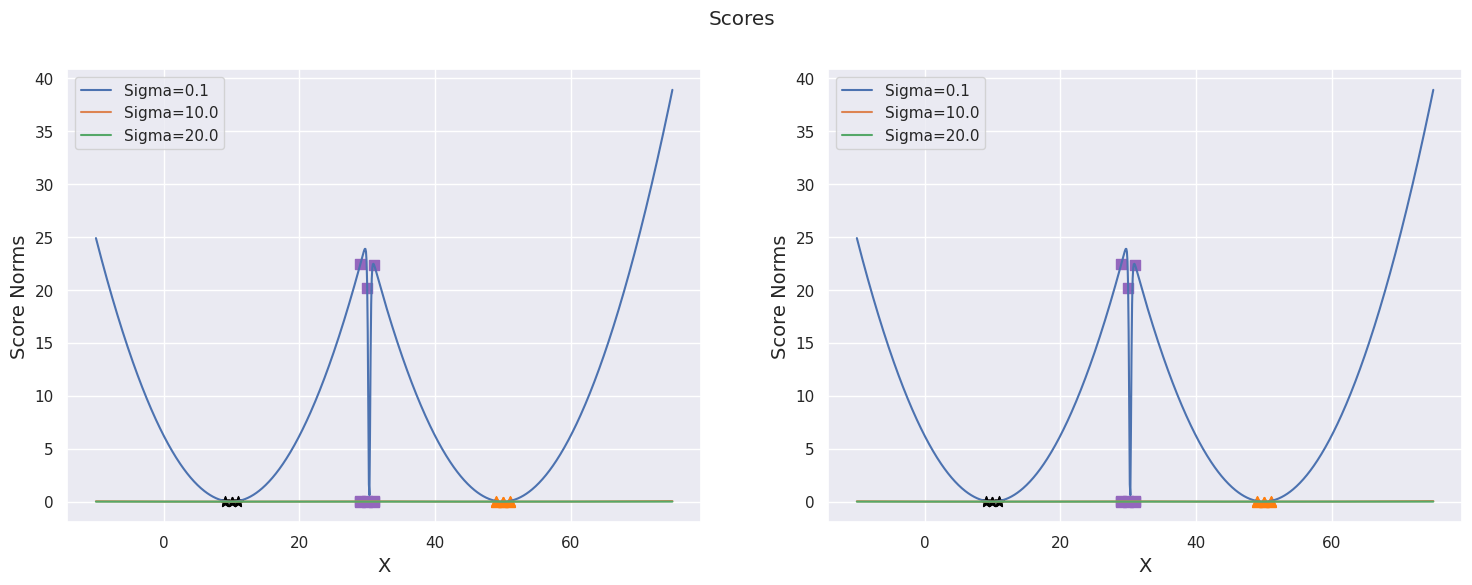

In [473]:
fig, axs = plt.subplots(1,2, figsize=(18,6))

for sigma_i, dist in zip(sigmas, pert_dists):
    _grad_norms = analytic_log_prob_grad_1d(dist, xs) ** 2
    _kp_norms = analytic_log_prob_grad_1d(dist, keypoints) ** 2
    
    axs[0].plot(xs, _grad_norms,  label="Sigma={:.1f}".format(sigma_i))
    axs[1].plot(xs, _grad_norms,  label="Sigma={:.1f}".format(sigma_i))

    for i, (kp, kpn, c, m, l) in enumerate(zip(keypoints, _kp_norms, colors, markers, regions)):
        if i%3 != 0: l=""
        axs[0].scatter(kp, kpn, marker=m, c=c, s=50)
        axs[1].scatter(kp, kpn, marker=m, c=c, s=50)

    
for ax in axs:
    ax.set(ylabel="Score Norms", xlabel="X")
    ax.legend()


# axs[0].set(yscale="linear",
#             xlim=(0,20), ylim=(-0.001, .01)
#           )

# axs[1].set(yscale="linear",
#             xlim=(45,55), ylim=(-0.001, .01)
#           )
for ax in axs:
#     ax.axvline(pt1, color="green", linestyle="--")
#     ax.axvline(pt2, color="green", linestyle="--")
    ax.legend()
plt.suptitle("Scores")

In [14]:
import matplotlib.pylab as pl

In [15]:
# %%time
# sigmas = np.linspace(0.3, 3, 10)
# estimates = []
# for s in sigmas:
#     estimates.append(
#         (analytic_log_prob_grad_1d(gmm_1D, xs, sigma_i=s)) ** 2
#     )

# colors = pl.cm.cool(np.linspace(0,1,10))

# fig, ax = plt.subplots(1,1, figsize=(12,6))
# # ax.set(cmap="winter")

# for i, (sigma, score) in enumerate(zip(sigmas, estimates)):
#     ax.plot(xs, score, label="{:.1f}".format(sigma), color=colors[i])

# ax.legend()

CPU times: user 34.6 ms, sys: 2.76 ms, total: 37.3 ms
Wall time: 34.5 ms


In [164]:
# # mu_l = list(np.linspace(3,18,13))
# # mu_m = list(np.linspace(44,58,15))
# # mu_r = list(np.linspace(80,95,13))
# # mus = [30, 70] + mu_l + mu_m + mu_r
# # mus = np.array(mus, dtype=np.float32)

# # n= len(mus)-2

# # mix_probs = [0.6, 0.395] + [0.05/n]*n 
# # mix_probs = np.array(mix_probs, dtype=np.float32)

# # scales =  [2, 2] + list(np.random.uniform(0.2, 0.45, n)) #[0.35]*n
# # scales = np.array(scales, dtype=np.float32)

# # xs = np.linspace(0,100,10000, dtype=np.float32)
# # x_tensor = xs.reshape(-1, 1)

# # normals = tfd.Normal(
# #     loc=mus,
# #     scale=scales
# # )

# # gmm_1D = tfd.MixtureSameFamily(
# #                 mixture_distribution=tfd.Categorical(probs=mix_probs),
# #                 components_distribution=normals
# # )

# # fig, ax = plt.subplots(1,1, figsize=(10,6))
# # ax.plot(xs[:], gmm_1D.prob(xs[:]))
# # ax.set(ylabel="Probability Density", xlabel="X", xlim=(0,100))

# splits = [23, 37, 63, 77, 100]

# keypoints=[]
# # keypoints += [mu_l[1], np.mean(mu_l[9:11]), 20]
# keypoints += [27, 30, 33]
# keypoints += [40, 50, 55, 60]
# keypoints += [67, 70, 73]
# # keypoints += [77, 87.5, 97]
# keypoints = np.array(keypoints, dtype=np.float32) #+1e-2
# len(keypoints)

# colors = sns.color_palette("bright") + sns.color_palette("dark")
# fig, ax = plt.subplots(1,1, figsize=(10,6))
# ax.plot(xs[:], gmm_1D.prob(xs[:]))
# cm = plt.cm.get_cmap('tab20')
# # cm = px.colors.qualitative.Light24
# ax.scatter(keypoints, gmm_1D.prob(keypoints), marker="x", c=keypoints, cmap=cm, alpha=1, s=100)
# ax.set(ylabel="Probability Density", xlabel="X", xlim=(0,100))

In [374]:
# %%time
# anal_grads = analytic_log_prob_grad_1d(gmm_1D, xs)
# est_grads = analytic_log_prob_grad_1d(gmm_1D, xs, sigma_i=1)

# anal_norms = anal_grads ** 2
# est_norms = est_grads ** 2

# fig, axs = plt.subplots(1,1, figsize=(10,6))
# axs.plot(xs, anal_grads, label="Original")
# axs.plot(xs, est_grads, label="Noise Conditioned")
# axs.set(title="Gradients")
# plt.legend()

CPU times: user 113 ms, sys: 4.58 ms, total: 117 ms
Wall time: 112 ms


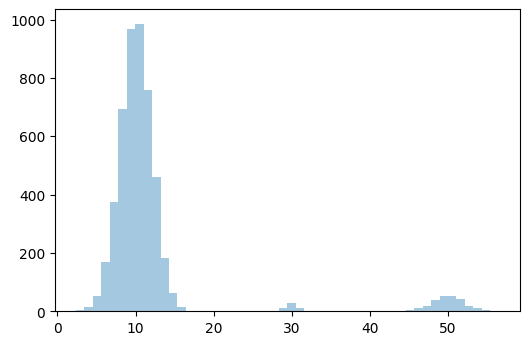

In [13]:
%%time
samples = gmm_1D.sample(5000).numpy()

samples = np.concatenate( (samples, np.random.uniform(29.0,31.0, 50))).astype(dtype=np.float32)

sns.distplot(samples, kde=False)

In [348]:
xs.shape

(1000,)

In [14]:
%%time
N = 3
estimates = []
keypoint_estimates = []
x_plot_grads = []

for s in sigmas:
    estimates.append(
        analytic_log_prob_grad_1d(gmm_1D, samples, sigma_i=s) ** 2 * s * s
    )
    keypoint_estimates.append(
        analytic_log_prob_grad_1d(gmm_1D, keypoints, sigma_i=s) ** 2 * s * s
    )
    x_plot_grads.append(
        analytic_log_prob_grad_1d(gmm_1D, xs, sigma_i=s) ** 2 * s * s
    )

estimates = np.stack(estimates)
keypoint_estimates = np.stack(keypoint_estimates)

_colors = pl.cm.jet(np.linspace(0,1,len(sigmas)))

fig, ax = plt.subplots(1,1, figsize=(12,6))
# ax.set(cmap="winter")

for i, (sigma, score) in enumerate(zip(sigmas, x_plot_grads)):
    ax.plot(xs, score, label="{:.2f}".format(sigma), color=_colors[i])
    for j, (kp, kpe) in enumerate(zip(keypoints, keypoint_estimates[i])):
        ax.scatter(kp, kpe, marker=markers[j], s=50, color=colors[j]) # c=keypoints, cmap=cm,
# ax.set(ylim=(-0.1,1), xlim=(60,80))
ax.legend()

NameError: name 'pl' is not defined

In [393]:
keypoint_estimates[0]

array([ 0.04000001,  0.        ,  0.04000001, 14.438929  , 12.960018  ,
       14.057495  ,  0.0400001 ,  0.        ,  0.0400001 ], dtype=float32)

In [145]:
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt

# px.colors.qualitative.Light24

In [459]:
estimates.shape

(3, 5050)

In [464]:
keypoint_estimates.T.shape

(9, 3)

In [524]:
plt.close()

In [527]:
fig = plt.Figure(figsize=(8,10))

# First subplot
ax = fig.add_subplot(2, 1, 1)
ax.scatter(*estimates[:2], s=1, alpha=0.1)

# Second subplot
ax2 = fig.add_subplot(2, 1, 2, projection='3d')

ax2.scatter(*estimates, s=1, alpha=0.1)
ax2.set_zlim(-1, 1)
plt.show()

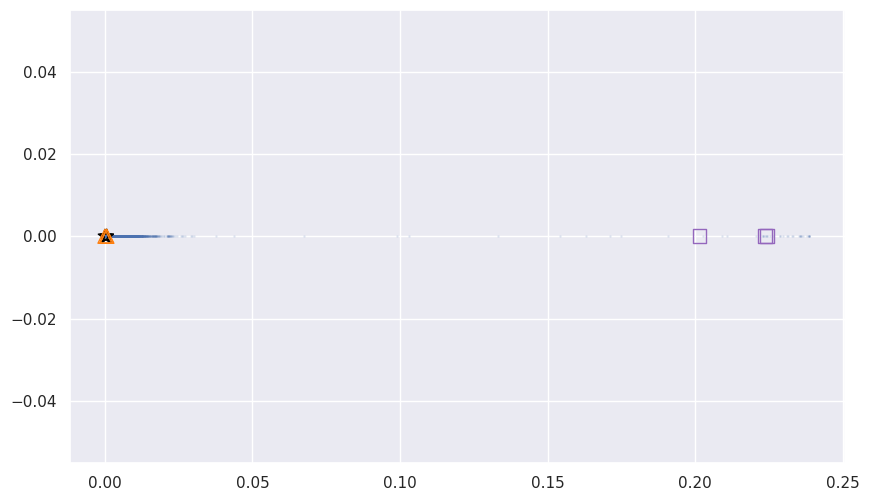

In [529]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.scatter(estimates[:1],np.zeros(estimates.shape[1]), s=1, alpha=0.1)

for i, kpe in enumerate(keypoint_estimates.T):
    ax.scatter(kpe[:1],0, marker=markers[i],  facecolors='none', edgecolors=colors[i], alpha=1, s=100 )
# ax.set(ylim)

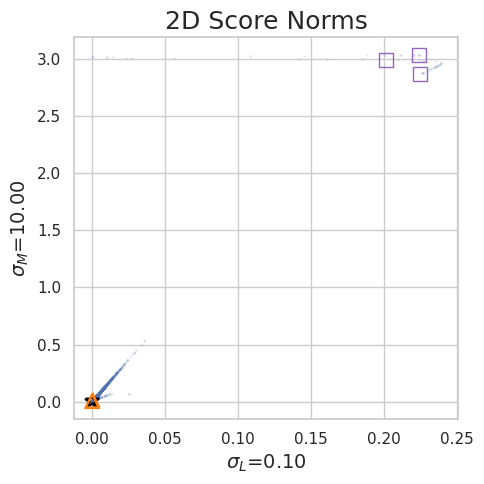

In [25]:
plt.close()

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(*estimates[:2], s=1, alpha=0.1)

for i, kp in enumerate(keypoint_estimates.T):
    ax.scatter(*kp[:2], marker=markers[i],  facecolors='none',
               edgecolors=colors[i], alpha=1, s=100)

ax.set(
    xlabel=r'$\sigma_L$={:.2f}'.format(sigmas[0]), 
#     xlim=(-0.001, xmax), xticks=np.arange(0.0, xmax, 0.005),
    ylabel=r'$\sigma_M$={:.2f}'.format(sigmas[1])
)
# ax.set(xlim=(-0.01,0.2))
# ax.set(ylim=(-0.005,0.05))

plt.title("2D Score Norms")
# plt.legend()
plt.tight_layout()
plt.savefig("Figures/scatter_2d_white.png", dpi=200, bbox_inches='tight')
plt.show()

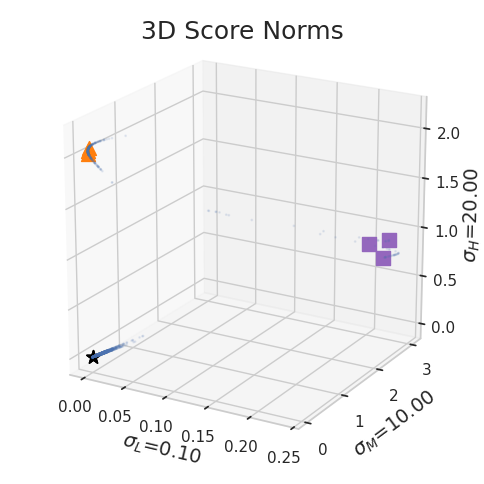

In [23]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(*estimates, s=1, alpha=0.1)

for i, kp in enumerate(keypoint_estimates.T):
    ax.scatter(*kp, marker=markers[i], c=colors[i], alpha=1, s=100 )

# rotate the axes and update
ax.view_init(20, -60)
xmax=0.02
ax.set(
    xlabel=r'$\sigma_L$={:.2f}'.format(sigmas[0]), 
#     xlim=(-0.001, xmax), xticks=np.arange(0.0, xmax, 0.005),
    ylabel=r'$\sigma_M$={:.2f}'.format(sigmas[1]),
#     ylim=(-0.001, 0.3)
    zlabel=r'$\sigma_H$={:.2f}'.format(sigmas[2]),
    yticks=np.arange(0.0, 3.1, 1.0)
)
plt.title("3D Score Norms")
plt.tight_layout()
plt.savefig("Figures/scatter_3d_white.png", dpi=200 ,bbox_inches='tight')
plt.show()

In [194]:
# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)

<Figure size 600x400 with 0 Axes>

In [280]:
# pts = keypoint_estimates.T
# fig = go.Figure()

# fig.add_trace(go.Scatter(
#     x=pts[:, 0],
#     y=pts[:, 1],
#     marker=dict(
#         symbol="x",
#         size=15,
#         color=keypoints,
#         colorbar=dict(
#             title="Colorbar"
#         ),
# #         colorscale=px.colors.qualitative.Light24
#     ),
#     text = keypoints,
#     mode="markers+text"))

# fig.add_trace(go.Scatter(
#     x=estimates.T[:, 1],
#     y=estimates.T[:, 2],
#     marker=dict(
#         symbol="circle",
#         size=3,
#         color="black",
#         colorbar=dict(
#             title="Colorbar"
#         ),
# #         colorscale=px.colors.qualitative.Light24
#     ),
#     mode="markers+text"))

# fig.show()

# colors = sns.color_palette("bright") + sns.color_palette("dark")
# fig, ax = plt.subplots(1,1, figsize=(10,6))
# ax.plot(xs[:], gmm_1D.prob(xs[:]))
# cm = plt.cm.get_cmap('tab20')
# # cm = px.colors.qualitative.Light24
# ax.scatter(keypoints, gmm_1D.prob(keypoints), marker="x", c=keypoints, cmap=cm, alpha=1, s=100)
# ax.set(ylabel="Probability Density", xlabel="X", xlim=(0,60))

In [171]:
import plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt


def plot_embedding(embedding, labels, captions=None, colors=None):
    
#     plt.figure(figsize=(10,10))

    emb3d = go.Scatter3d(
        x=embedding[:,0],
        y=embedding[:,1],
        z=embedding[:,2],
        mode="markers",
        name="Score Norms",
        marker=dict(
            size=2,
            color="black",
#             colorscale=colors,
            opacity=0.1,
#             showscale=True
        ),
#         text=captions
    )

    layout = go.Layout(
        title="Score Norms",
    
        autosize=False,
        width=800,
        height=800,
        paper_bgcolor='#F5F5F5',
        template="plotly",
        
        margin=dict(
                l=1,
                r=1,
                b=1,
                t=1),
    scene = dict(
        xaxis = dict(
            title='Low={:.2f}'.format(sigmas[0]),
            range=[-0.01, 0.1]
        ),
        yaxis = dict(
            title='Med={:.2f}'.format(sigmas[1]),
            range=[-0.01,1]
        ),
        zaxis = dict(
            title='High={:.2f}'.format(sigmas[2]),
#             range=[0,3]
        )
    )
)

    data=[emb3d]

    fig = go.Figure(data=data, layout=layout)

    return fig

In [281]:
# plot_samples = estimates.T.copy()
# plot_samples += (np.random.normal(0, 5e-4, size=(len(samples),3)))

# cm = plt.cm.get_cmap('tab20')
# colors = cm.colors

# colors = ["blue", "red", "green", "yellow", "black"]
# colors = ["black", "red", "black", "yellow", "black"]
# splits = [23, 37, 63, 78.5, 100]

# fig = plot_embedding(plot_samples, samples)


# pts = keypoint_estimates.T
# cm = plt.cm.get_cmap('tab20')
# keypoint_colors = cm.colors

# markers = go.Scatter3d(
#     x=pts[:,0],
#     y=pts[:,1],
#     z=pts[:,2],
#     mode="markers+text",
#     text=keypoints,
#     name="Key Points",
#     marker=dict(
#         size=5,
#         color=keypoints,
#         symbol="x",
# #         color_continuous_scale=["red", "green", "blue"],
# #         colorscale=px.colors.qualitative.Light24,
#         opacity=1,
#         showscale=True
#     ),
# #         text=captions
# )

# fig.add_trace(markers)
# fig.show()

[Text(0, 0.5, 'Probability Density'), (0.0, 20.0), Text(0.5, 0, 'X')]

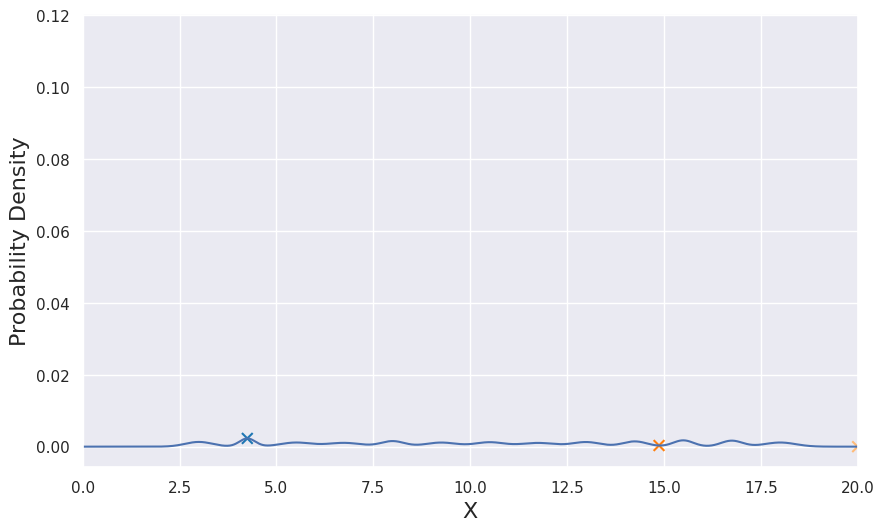

In [61]:
colors = sns.color_palette("bright") + sns.color_palette("dark")
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(xs[:], gmm_1D.prob(xs[:]))
cm = plt.cm.get_cmap('tab20')
ax.scatter(keypoints, gmm_1D.prob(keypoints), marker="x", s=60, c=keypoints, cmap=cm, alpha=1)
ax.set(ylabel="Probability Density", xlabel="X", xlim=(0,20))

In [190]:
# fig.write_html("gmm_norms_jittered_5k.html")